In [2]:
import pandas
import pathlib
from matplotlib import pyplot as plt
from config import datadir

import scipy.optimize
import numpy
from tbcontrol.responses import fopdt, sopdt

In [3]:
excel_directory = pandas.read_excel(datadir/'Data Description.xlsx', parse_dates=True, index_col='Start Date') #Loads complete excel directory used to organise datasets
excel_directory

,End Date,Equipment,Type,Purpose,Filename,Run,Description
Start Date,,,,,,,
2019-12-06,2019-12-11,pH Probe,Raw,Test Drift on pH probe,20191206 pH Drift 1.txt,1,"long run of pH probe drift, performed inside t..."
2019-12-11,2019-12-17,pH Probe,Raw,Test Drift on pH probe,20191211 pH Drift 2.txt,2,"long run of pH probe drift, performed inside t..."
2019-12-17,2019-12-23,pH Probe,Raw,Test Drift on pH probe,20191217 pH Drift 3.txt,3,"long run of pH probe Drift, circulating ph7 bu..."
2020-01-16,2020-01-16,pH Probe,Raw,Step Test,20200116 pH Step 3.txt,3,pH stepped outside of rig
2020-01-14,2020-01-14,pH Probe,Raw,Step Test,20200114 pH Step 1.broken,1,"pH stepped outside of rig. Probe Broke, Dump run"
2020-01-15,2020-01-15,pH Probe,Raw,Step Test,20200115 pH Step 2.txt,2,pH stepped outside of rig
2020-01-01,2020-01-01,Pumps,Calibration,Calibration,Pump Calibration.xlsx,1,Calibration data for all pumps
2019-12-06,2019-12-11,pH Probe,Drift,Test Drift on pH probe,20191206 pH Drift 1.csv,1,"long run of pH probe drift, performed inside t..."
2019-12-11,2019-12-17,pH Probe,Drift,Test Drift on pH probe,20191211 pH Drift 2.csv,2,"long run of pH probe drift, performed inside t..."


In [4]:
steps = excel_directory[(excel_directory['Type']=='Step Test')]    # Creates a new directory of only the raw data files to be cleaned 
                                                            # Use '&' for multiple conditions

In [5]:
external_steps = pandas.read_csv(datadir /'20200115 pH Step 2.csv')
external_steps

,DateTime,Temp,pH,Boolean Dosing Pump,Gas Analyser CO2,Gas Analyser O2,Air Feed Rate,Feed Rpm,Dosing Rpm,Dosing average?
0,2020-01-15 11:59:11,293.801689,7.074204,0.0,-0.133293,20.541316,-0.595911,-0.264864,0.0,0.0
1,2020-01-15 11:59:12,293.802309,7.074330,0.0,-0.132989,20.539398,-0.595271,-0.340608,0.0,0.0
2,2020-01-15 11:59:13,293.802142,7.075654,0.0,-0.133887,20.540856,-0.587329,-0.340926,0.0,0.0
3,2020-01-15 11:59:14,293.801788,7.079847,0.0,-0.133310,20.543014,-0.579549,-0.342092,0.0,0.0
4,2020-01-15 11:59:15,293.802407,7.082653,0.0,-0.127567,20.541316,-0.579643,-0.340528,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
90683,2020-01-16 13:10:34,293.048022,13.038681,0.0,-0.131598,20.510447,-0.579599,-0.266268,0.0,0.0
90684,2020-01-16 13:10:35,293.048218,13.038362,0.0,-0.132265,20.510907,-0.595716,-0.318001,0.0,0.0
90685,2020-01-16 13:10:36,293.048454,13.038238,0.0,-0.132613,20.513844,-0.569260,-0.263168,0.0,0.0
90686,2020-01-16 13:10:37,293.047766,13.038757,0.0,-0.132558,20.510168,-0.579432,-0.264307,0.0,0.0


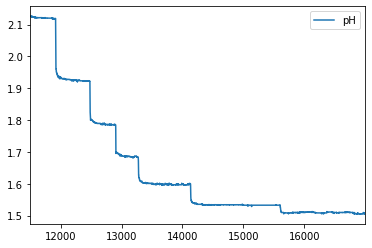

In [6]:
external_steps[11500:17000].plot(y='pH')

## Single FOPDT

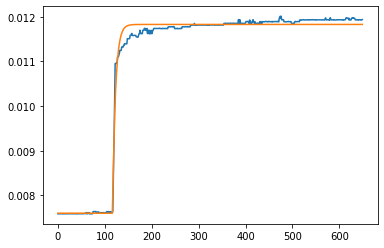

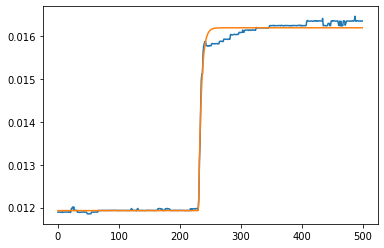

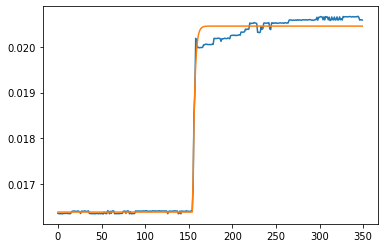

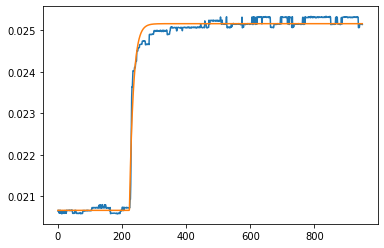

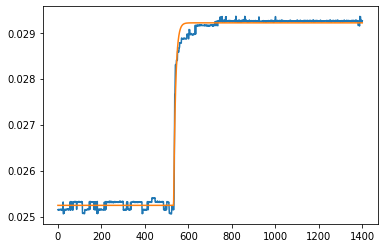

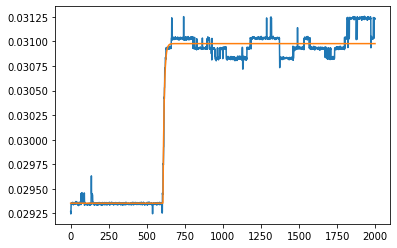

In [15]:
spans=[[11800,12450],[12250,12750],[12750,13100],[13050,14000],[13600,15000],[15000,17000]]


ph_list = []
poh_list = []
ph_delogged = []
poh_delogged = []
time_list = []

K_list, tau_list, theta_list, y0_list = [], [], [], []

R_squared_single = []

for number, span in enumerate(spans):
    lower = span[0]
    upper = span[1]
    
    time_set = numpy.array(external_steps['DateTime'][lower:upper].index.tolist())-lower
    ph_set = numpy.array(external_steps['pH'][lower:upper].values)
    poh_set = 14 - ph_set
    ph_delogged_set = 10**(-ph_set)
    poh_delogged_set = 10**(-poh_set)
    
#     print (poh_set)
    
    time_list.append(time_set)
    
    ph_list.append(ph_set)
    poh_list.append(poh_set)
    
    ph_delogged.append(ph_delogged_set)
    poh_delogged.append(poh_delogged_set)
    
    [K, tau, theta, y0], _ = scipy.optimize.curve_fit(fopdt, time_set, 
                                                      ph_delogged_set, [0.004, 4, 200, 50])
    
    K_list.append(K)
    tau_list.append(tau)
    theta_list.append(theta)
    y0_list.append(y0)
    
    data_average = numpy.average(ph_delogged_set)
    sum_squares_total = sum((ph_delogged_set - data_average)**2)
    
    predicted_data = fopdt(time_set, K, tau, theta, y0)
    
    sum_squares_residual = sum((ph_delogged_set - predicted_data)**2)
    
    R_squared_single.append(1 - (sum_squares_residual/sum_squares_total))
    
#     print('Span {0} \n R^2 {1} \n'.format(number+1, R_squared_single[-1]), ' \n k {0} \n\n tau {1} \n\n theta {2} \n\n y0 {3} \n'.format(K, tau,  theta,  y0))
    
    figure = plt.figure()
    
    plt.plot(time_set, ph_delogged_set)
    plt.plot(predicted_data)


In [16]:
K = numpy.average(K_list[:-1])
tau = numpy.average(tau_list[:-1])
K, tau

(0.004207212268282716, 6.82834462239835)

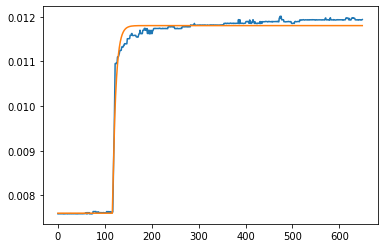

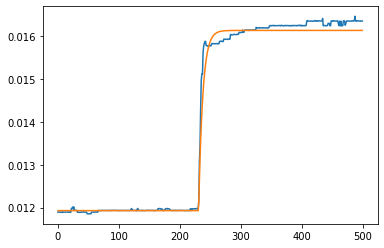

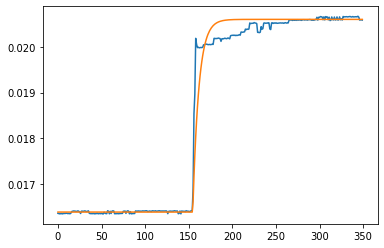

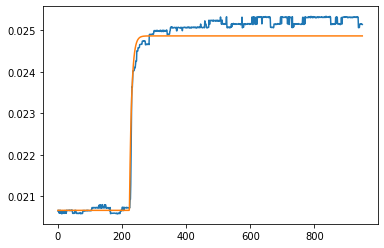

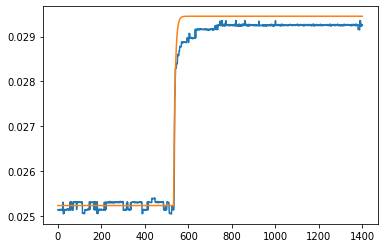

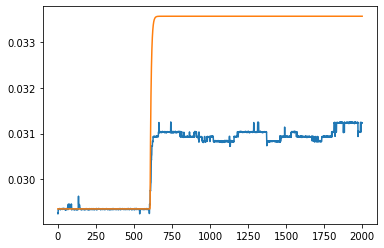

In [17]:
for time_set, ph_delogged_set, theta, y0 in zip(time_list, ph_delogged, theta_list, y0_list):
    figure = plt.figure()
    
    plt.plot(time_set, ph_delogged_set)
    plt.plot(fopdt(time_set, K, tau, theta, y0))

## 2 Parrallel FOPDT's

In [70]:
def parallel_fopdt(t, K_sum, k1, tau1, theta1, y01, tau2, theta2, y02):
    k2 = K_sum - k1
    fopdt1 = fopdt(t, k1, tau1, theta1, y01)
    fopdt2 = fopdt(t, k2, tau2, theta2, y02)
    
    return fopdt1 + fopdt2

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\tbcontrol\responses.py:18: RuntimeWarning: overflow encountered in multiply
  return y0 + numpy.sign(K)*numpy.maximum(0, abs(K)*(1 - numpy.exp(-(t - theta)/tau)))


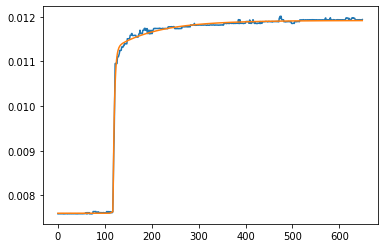

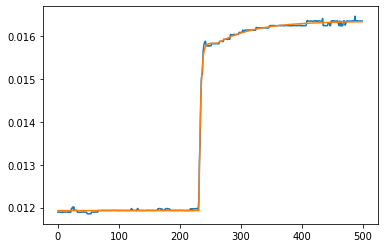

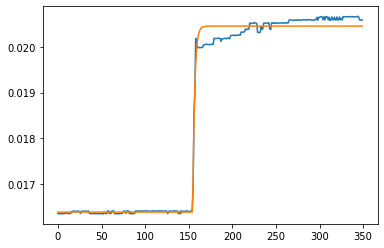

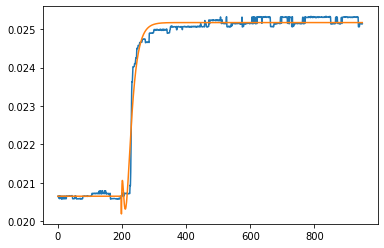

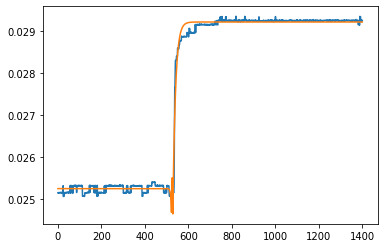

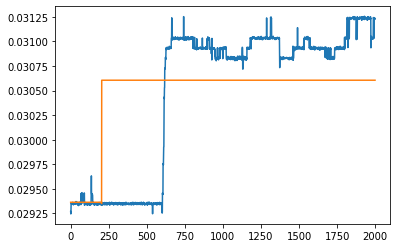

In [71]:
spans=[[11800,12450],[12250,12750],[12750,13100],[13050,14000],[13600,15000],[15000,17000]]


ph_list = []
poh_list = []
ph_delogged = []
poh_delogged = []
time_list = []

K1_list, tau1_list, theta1_list, y01_list = [], [], [], []
K2_list, tau2_list, theta2_list, y02_list = [], [], [], []

R_squared_parallel = []

for number, span in enumerate(spans):
    lower = span[0]
    upper = span[1]
    
    time_set = numpy.array(external_steps['DateTime'][lower:upper].index.tolist())-lower
    ph_set = numpy.array(external_steps['pH'][lower:upper].values)
    poh_set = 14 - ph_set
    ph_delogged_set = 10**(-ph_set)
    poh_delogged_set = 10**(-poh_set)
    
#     print (poh_set)
    
    time_list.append(time_set)
    
    ph_list.append(ph_set)
    poh_list.append(poh_set)
    
    ph_delogged.append(ph_delogged_set)
    poh_delogged.append(poh_delogged_set)
    
    [K_sum, k1, tau1, theta1, y01, tau2, theta2, y02], _ = scipy.optimize.curve_fit(parallel_fopdt, time_set, 
                                                      ph_delogged_set, 
                                                      [0.004, 0.004, 4, 200, 50, 4, 200, 50])  #K_sum, k1, tau1, theta1, y01, tau2, theta2, y02
    
    k2 = K_sum - k1
    
    
    K1_list.append(k1)
    tau1_list.append(tau1)
    theta1_list.append(theta1)
    y01_list.append(y01)
    
    K2_list.append(k2)
    tau2_list.append(tau2)
    theta2_list.append(theta2)
    y02_list.append(y02)
        
    data_average = numpy.average(ph_delogged_set)
    sum_squares_total = sum((ph_delogged_set - data_average)**2)
    
    predicted_data = parallel_fopdt(time_set, K_sum, k1, tau1, theta1, y01, tau2, theta2, y02)
    
    sum_squares_residual = sum((ph_delogged_set - predicted_data)**2)
    
    R_squared_parallel.append(1 - (sum_squares_residual/sum_squares_total))
    
#     print('Span {0} \n R^2 {1}\n Combined Gain {2} \n'.format(number+1, R_squared_parallel[-1], K_sum), ' \n k1 {0} \n k2 {1} \n\n tau1 {2} \n tau2 {3} \n\n theta1 {4} \n theta2 {5} \n\n y01 {6} \n y02 {7} \n'.format(k1, k2, tau1, tau2, theta1, theta2, y01, y02))
    
    figure = plt.figure()
    
    plt.plot(time_set, ph_delogged_set)
    plt.plot(predicted_data)


K = numpy.average(K_list[:-1])
tau = numpy.average(tau_list[:-1])
K, tau

for time_set, ph_delogged_set, theta, y0 in zip(time_list, ph_delogged, theta_list, y0_list):
    figure = plt.figure()
    
    plt.plot(time_set, ph_delogged_set)
    plt.plot(fopdt(time_set, K, tau, theta, y0))

In [49]:
count_2 = 0

for r1, r2 in zip(R_squared_single, R_squared_parallel):
    if r2>r1:
        string_custom = 'Parrelel provides a better fit by R squared'
        count_2 += 1
    else:
        string_custom = 'Singular provides a better fit by R squared'
        count_2 -= 1
    print (r1, r2, string_custom)

count_2

0.994749429707115 0.9489753831782115 Singular provides a better fit by R squared
0.9967978951300317 0.996051086418059 Singular provides a better fit by R squared
0.9944010143347659 0.9986299943881906 Parrelel provides a better fit by R squared
0.9945575523391491 0.9914755861034188 Singular provides a better fit by R squared
0.9969811088626273 0.9953058948858793 Singular provides a better fit by R squared
0.9812525806652087 0.9812314723019882 Singular provides a better fit by R squared


-4

In [50]:
K_list, K1_list, K2_list

([0.004233480597973648,
  0.004268643963811211,
  0.004060767755792508,
  0.004502287923417629,
  0.003970881100418581,
  0.0016241795615382542],
 [0.04502223519583769,
  -0.0532036238226691,
  -0.0037130967481041454,
  -0.1107032077802927,
  -0.03943012994404935,
  -0.02257224904480259],
 [-0.04982332262673117,
  0.04892332025732739,
  -0.0004705575864615858,
  0.10581789644839555,
  0.03539899160851241,
  0.02095012740330083])

## Parrelel with deadtime Offset and negative sum rather than positive

In [59]:
def parallel_fopdt(t, K_sum, k1, tau1, theta1, y01, tau2, theta2_offset, y02):
    k2 = K_sum - k1
    fopdt1 = fopdt(t, k1, tau1, theta1, y01)
    fopdt2 = fopdt(t, k2, tau2, theta2_offset + theta1, y02)
    
    return fopdt1 - fopdt2

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


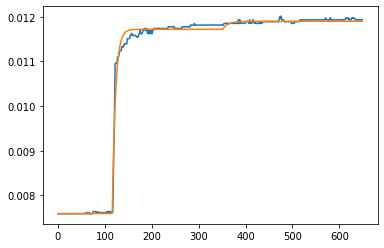

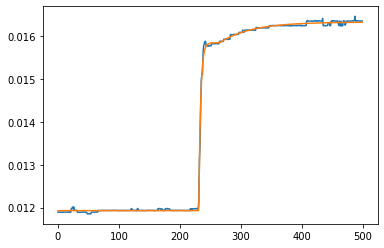

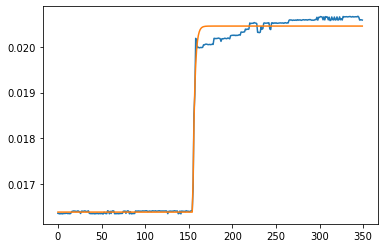

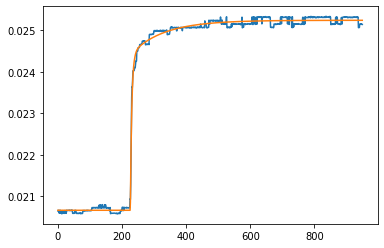

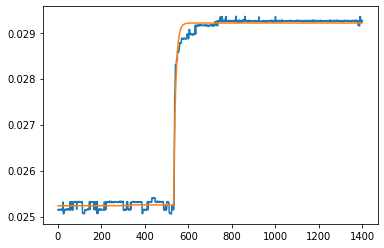

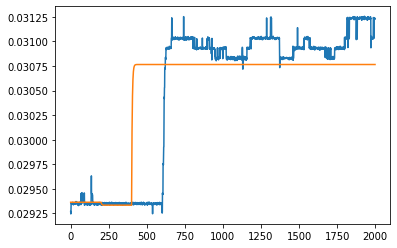

In [63]:
spans=[[11800,12450],[12250,12750],[12750,13100],[13050,14000],[13600,15000],[15000,17000]]


ph_list = []
poh_list = []
ph_delogged = []
poh_delogged = []
time_list = []

K1_list, tau1_list, theta1_list, y01_list = [], [], [], []
K2_list, tau2_list, theta2_list, y02_list = [], [], [], []

R_squared_parallel = []

for number, span in enumerate(spans):
    lower = span[0]
    upper = span[1]
    
    time_set = numpy.array(external_steps['DateTime'][lower:upper].index.tolist())-lower
    ph_set = numpy.array(external_steps['pH'][lower:upper].values)
    poh_set = 14 - ph_set
    ph_delogged_set = 10**(-ph_set)
    poh_delogged_set = 10**(-poh_set)
    
#     print (poh_set)
    
    time_list.append(time_set)
    
    ph_list.append(ph_set)
    poh_list.append(poh_set)
    
    ph_delogged.append(ph_delogged_set)
    poh_delogged.append(poh_delogged_set)
    
    [K_sum, k1, tau1, theta1, y01, tau2, theta2_offset, y02], _ = scipy.optimize.curve_fit(parallel_fopdt, time_set, 
                                                      ph_delogged_set, 
                                                      [0.004, 0.004, 4, 200, 50, 4, 200, 50])  #K_sum, k1, tau1, theta1, y01, tau2, theta2, y02
    
    k2 = K_sum - k1
    
    theta2 = theta1 + theta2_offset
    
    K1_list.append(k1)
    tau1_list.append(tau1)
    theta1_list.append(theta1)
    y01_list.append(y01)
    
    K2_list.append(k2)
    tau2_list.append(tau2)
    theta2_list.append(theta2)
    y02_list.append(y02)
        
    data_average = numpy.average(ph_delogged_set)
    sum_squares_total = sum((ph_delogged_set - data_average)**2)
    
    predicted_data = parallel_fopdt(time_set, K_sum, k1, tau1, theta1, y01, tau2, theta2_offset, y02)
    
    sum_squares_residual = sum((ph_delogged_set - predicted_data)**2)
    
    R_squared_parallel.append(1 - (sum_squares_residual/sum_squares_total))
    
#     print('Span {0} \n R^2 {1}\n Combined Gain {2} \n'.format(number+1, R_squared_parallel[-1], K_sum), ' \n k1 {0} \n k2 {1} \n\n tau1 {2} \n tau2 {3} \n\n theta1 {4} \n theta2 {5} {6} \n\n y01 {6} \n y02 {7} \n'.format(k1, k2, tau1, tau2, theta1, theta2, theta2_offset, y01, y02))
    
    figure = plt.figure()
    
    plt.plot(time_set, ph_delogged_set)
    plt.plot(predicted_data)


## Series

In [64]:
def parallel_fopdt(t, K_sum, k1, tau1, theta1, y01, tau2, theta2, y02):
    k2 = K_sum - k1
    fopdt1 = fopdt(t, k1, tau1, theta1, y01)
    fopdt2 = fopdt(t, k2, tau2, theta2, y02)
    
    return fopdt1 * fopdt2

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\tbcontrol\responses.py:18: RuntimeWarning: overflow encountered in multiply
  return y0 + numpy.sign(K)*numpy.maximum(0, abs(K)*(1 - numpy.exp(-(t - theta)/tau)))


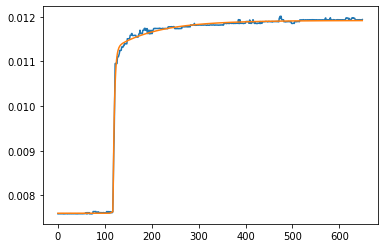

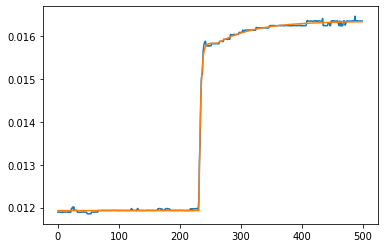

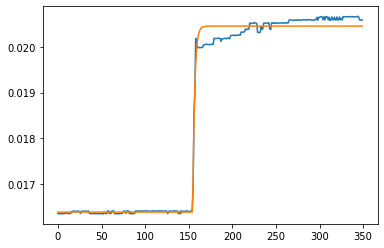

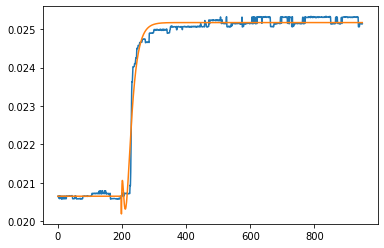

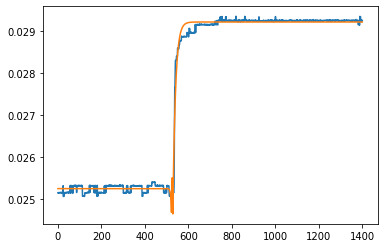

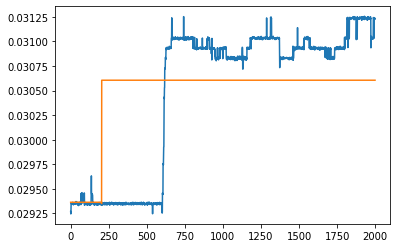

In [72]:
spans=[[11800,12450],[12250,12750],[12750,13100],[13050,14000],[13600,15000],[15000,17000]]


ph_list = []
poh_list = []
ph_delogged = []
poh_delogged = []
time_list = []

K1_list, tau1_list, theta1_list, y01_list = [], [], [], []
K2_list, tau2_list, theta2_list, y02_list = [], [], [], []

R_squared_parallel = []

for number, span in enumerate(spans):
    lower = span[0]
    upper = span[1]
    
    time_set = numpy.array(external_steps['DateTime'][lower:upper].index.tolist())-lower
    ph_set = numpy.array(external_steps['pH'][lower:upper].values)
    poh_set = 14 - ph_set
    ph_delogged_set = 10**(-ph_set)
    poh_delogged_set = 10**(-poh_set)
    
#     print (poh_set)
    
    time_list.append(time_set)
    
    ph_list.append(ph_set)
    poh_list.append(poh_set)
    
    ph_delogged.append(ph_delogged_set)
    poh_delogged.append(poh_delogged_set)
    
    [K_sum, k1, tau1, theta1, y01, tau2, theta2, y02], _ = scipy.optimize.curve_fit(parallel_fopdt, time_set, 
                                                      ph_delogged_set, 
                                                      [0.004, 0.004, 4, 200, 50, 4, 200, 50])  #K_sum, k1, tau1, theta1, y01, tau2, theta2, y02
    
    k2 = K_sum - k1
    
#     theta2 = theta1 + theta2_offset
    
    K1_list.append(k1)
    tau1_list.append(tau1)
    theta1_list.append(theta1)
    y01_list.append(y01)
    
    K2_list.append(k2)
    tau2_list.append(tau2)
    theta2_list.append(theta2)
    y02_list.append(y02)
        
    data_average = numpy.average(ph_delogged_set)
    sum_squares_total = sum((ph_delogged_set - data_average)**2)
    
    predicted_data = parallel_fopdt(time_set, K_sum, k1, tau1, theta1, y01, tau2, theta2, y02)
    
    sum_squares_residual = sum((ph_delogged_set - predicted_data)**2)
    
    R_squared_parallel.append(1 - (sum_squares_residual/sum_squares_total))
    
#     print('Span {0} \n R^2 {1}\n Combined Gain {2} \n'.format(number+1, R_squared_parallel[-1], K_sum), ' \n k1 {0} \n k2 {1} \n\n tau1 {2} \n tau2 {3} \n\n theta1 {4} \n theta2 {5} {6} \n\n y01 {6} \n y02 {7} \n'.format(k1, k2, tau1, tau2, theta1, theta2, theta2_offset, y01, y02))
    
    figure = plt.figure()
    
    plt.plot(time_set, ph_delogged_set)
    plt.plot(predicted_data)
